In [31]:
SEED = 42


import numpy as np
np.random.seed(SEED)

import pandas as pd
import re 
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
tf.random.set_seed(SEED)
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

# import tokenization
from bert import tokenization

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [2]:
TARGET = "AI"
DATASET_PATH = "dataset.pickle"
TRAIN_PATH = 'train.pkl'
TEST_PATH = 'test.pkl'

In [3]:
df = pd.read_pickle(DATASET_PATH)
df

,crunchbase_ID,home_text,aboutus_text,overview_text,whatwedo_text,company_text,whoweare_text,AI
0,1916,Skip to main content Products GPU accelerated ...,NaN,NaN,NaN,NaN,NaN,1
1,1917,Our AIs Research Company Careers Get in Touch ...,NaN,NaN,NaN,Our AIs Research Company Careers Get in Touch ...,NaN,1
2,1918,Toggle navigation Product Projects Company His...,NaN,NaN,NaN,NaN,NaN,1
3,1919,Brainpeek Solutions Create a seamless online u...,Brainpeek Solutions Create a seamless online u...,NaN,NaN,NaN,NaN,1
4,1920,The Tool Our Languages Services Extract Produc...,The Tool Our Languages Services Extract Produc...,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...
4889,2735,Username or Email L senord Remember me Norsk S...,Username or Email L senord Remember me Norsk S...,NaN,NaN,NaN,NaN,0
4890,5944,Solutions Solution for distributors Covered re...,NaN,NaN,NaN,NaN,NaN,0
4891,5251,BROWSE PRODUCTS Variety Cases Pasta Mac and Ch...,NaN,NaN,NaN,NaN,NaN,0
4892,4225,Pricing Documentation Community Changelog Logi...,NaN,NaN,NaN,NaN,NaN,0


In [25]:
df.isnull().mean()

text    0.0
AI      0.0
dtype: float64

## Bert Functions

In [4]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

def build_model(bert_layer, lr, max_len=50):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    out = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(out)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

## PreProcessing Functions

In [6]:
def remove_non_alphabets(X):
    regs = []
    for sent in X:
        x = re.sub('[^A-Za-z]'," ",str(sent))
        regs.append(x)
    return regs


def create_corpus(X):
    """Decompose text to corpus (e.g. `This is a pen` to [ `This`, `is`, `a`, `pen` ])
    
    Arguments:
        texts: list(str) / Text list.
        
    Returns:
        list(str) / Corpus list.
    """
    
    corpus = []
    for sent in X:
        words = [ word.lower() for word in word_tokenize(sent) ]
        corpus.append(words)
        
    return corpus


def remove_stopwords(X):
    stop_words = set(stopwords.words('english'))
    filterd_words = []
    keep = ["n't", "not", "no"]
    for words in X:
        x = [word for word in words if word not in stop_words or word in keep] 
        filterd_words.append(x)
    return filterd_words


def lemmatize(X):
    """taking the root of every word"""
    lemmatized = []
    for words in X:
        x = [WordNetLemmatizer().lemmatize(word) for word in words]
        lemmatized.append(x)
    return lemmatized


def remove_unnecessary_words(X):
    """taking words that are bigger than 2"""
    filterd = []
    for words in X:
        x = [word for word in words if len(word) >= 2]
        filterd.append(x)
    return filterd    

## Preprocessing

In [7]:
df_home_text = df[['home_text', 'AI']].set_axis( ['text', 'AI'], axis=1)
df_aboutus_text = df[df['aboutus_text'].notnull()][['aboutus_text', 'AI']].set_axis( ['text', 'AI'], axis=1)
df_overview_text = df[df['overview_text'].notnull()][['overview_text', 'AI']].set_axis( ['text', 'AI'], axis=1)
df_whatwedo_text = df[df['whatwedo_text'].notnull()][['whatwedo_text', 'AI']].set_axis( ['text', 'AI'], axis=1)
df_company_text = df[df['company_text'].notnull()][['company_text', 'AI']].set_axis( ['text', 'AI'], axis=1)
df_whoweare_text = df[df['whoweare_text'].notnull()][['whoweare_text', 'AI']].set_axis( ['text', 'AI'], axis=1)

In [8]:
df = pd.concat([df_home_text, df_aboutus_text, df_overview_text, df_whatwedo_text, df_company_text, df_whoweare_text], axis=0, ignore_index=True)
df = df.sample(frac=1, random_state=SEED)

In [9]:
X = df['text'].values.astype(str)
y = df[TARGET].values

In [10]:
%%time

X = remove_non_alphabets(X)
X = create_corpus(X)
X = remove_stopwords(X)
X = lemmatize(X)
X = remove_unnecessary_words(X)

Wall time: 44.6 s


In [11]:
tmp = [" ".join(x) for x in X]
X = np.array(tmp, dtype='object')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)

In [12]:
train = [X_train, y_train]
test = [X_test, y_test]
joblib.dump(train, TRAIN_PATH)
joblib.dump(test, TEST_PATH);

In [13]:
# train_set = joblib.load(TRAIN_PATH)
# X_train = train_set[0]
# y_train = train_set[1]

# test_set = joblib.load(TEST_PATH)
# X_test = test_set[0]
# y_test = test_set[1]

## Modeling

In [14]:
%%time
module_url = "bert_model"
bert_layer = hub.KerasLayer(module_url, trainable=True)

Wall time: 57.9 s


In [15]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [16]:
max_len = 35
X_train = bert_encode(X_train, tokenizer, max_len=max_len)
X_test = bert_encode(X_test, tokenizer, max_len=max_len)

In [17]:
lr = 1e-5
model = build_model(bert_layer, lr, max_len=max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 35)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 35)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [18]:
%%time
checkpoint = ModelCheckpoint('bert_model_2.h5', monitor='val_accuracy', save_best_only=True)
early_stoping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=10,
    callbacks=[checkpoint, early_stoping],
    batch_size=6   # so low because of the memory
)

Train on 6302 samples, validate on 701 samples
Epoch 1/10
6302/6302 [==============================] - 431s 68ms/sample - loss: 0.4851 - accuracy: 0.7598 - val_loss: 0.3728 - val_accuracy: 0.8445
Epoch 2/10
6302/6302 [==============================] - 398s 63ms/sample - loss: 0.2266 - accuracy: 0.9080 - val_loss: 0.3785 - val_accuracy: 0.8531
Epoch 3/10
6302/6302 [==============================] - 390s 62ms/sample - loss: 0.0654 - accuracy: 0.9797 - val_loss: 0.4102 - val_accuracy: 0.8716
Epoch 4/10
6302/6302 [==============================] - 391s 62ms/sample - loss: 0.0337 - accuracy: 0.9889 - val_loss: 0.4735 - val_accuracy: 0.8759
Epoch 5/10
6302/6302 [==============================] - 393s 62ms/sample - loss: 0.0272 - accuracy: 0.9916 - val_loss: 0.5194 - val_accuracy: 0.8787
Epoch 6/10
6302/6302 [==============================] - 340s 54ms/sample - loss: 0.0258 - accuracy: 0.9900 - val_loss: 0.6672 - val_accuracy: 0.8559
Epoch 7/10
6302/6302 [==============================] - 341

In [23]:
model.load_weights('bert_model_2.h5')

In [24]:
model.evaluate(X_test, y_test)

779/779 [==============================] - 9s 11ms/sample - loss: 0.6599 - accuracy: 0.8460


[0.6599028228336182, 0.8459563]

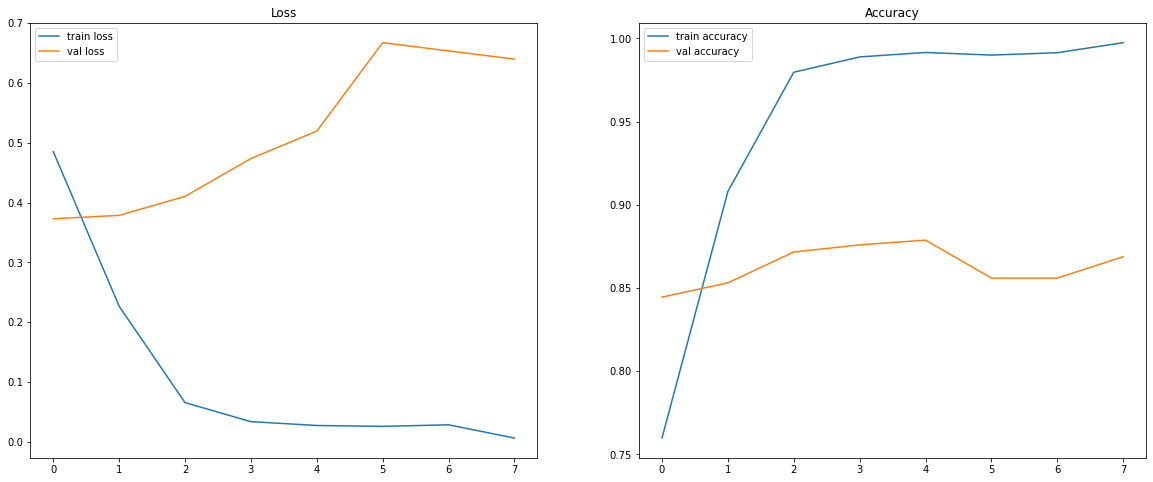

In [28]:
train_loss = history.history['loss']         # train loss
train_acc = history.history['accuracy']      # train accuracy
val_loss = history.history['val_loss']       # validation loss
val_acc = history.history['val_accuracy']    # validation accuracy

# Plotting 
plt.figure(figsize=(20, 8))   # figure size

plt.subplot(1, 2, 1)          # first plot: loss plot
# line plot
plt.plot( train_loss, label='train loss')   # train loss line plot
plt.plot( val_loss, label='val loss')       # validation loss line plot

plt.title('Loss')     # plot title
plt.legend()          # to display labels

plt.subplot(1, 2, 2)         # second plot: accuracy plot
# line plot
plt.plot(train_acc, label='train accuracy')    # train accuracy line plot
plt.plot(val_acc, label='val accuracy')        # validation accuracy line plot

plt.title('Accuracy')    # plot title
plt.legend()             # to display labels
plt.show();

In [30]:
preds = model.predict(X_test).round().astype(int)

conf = confusion_matrix(y_test, preds)
sns.heatmap(conf, annot=True);
plt.xlabel('Predicted')
plt.ylabel('Actual');

NameError: name 'confusion_matrix' is not defined